In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
import joblib
import geopandas as gpd
from shapely.geometry import Point

# plotting defaults
plt.rcParams.update({"figure.figsize": (8, 6), "font.size": 12})
RANDOM_STATE = 42

In [2]:
df2023 = pd.read_csv("../data/master.csv", parse_dates=True, low_memory=False)[["Latitude", "Longitude", "U_ppb"]]

# Inspect columns (run to see what's available)
df2023.columns.tolist()

['Latitude', 'Longitude', 'U_ppb']

In [3]:
lat_col = "Latitude"
lon_col = "Longitude"
u_col   = "U_ppb"

In [4]:
  # ensure lat/lon and target exist and are numeric
df2023[lat_col] = pd.to_numeric(df2023[lat_col], errors="coerce")
df2023[lon_col] = pd.to_numeric(df2023[lon_col], errors="coerce")
df2023[u_col] = pd.to_numeric(df2023[u_col], errors="coerce")

# drop rows missing critical information
df2023 = df2023.dropna(subset=[lat_col, lon_col, u_col]).reset_index(drop=True)
print("Rows after dropping NA:", len(df2023))

# quick stats
df2023[u_col].describe()

Rows after dropping NA: 908


count    908.000000
mean      26.028293
std       27.546255
min        0.040000
25%        7.807500
50%       19.540000
75%       34.727500
max      306.600000
Name: U_ppb, dtype: float64

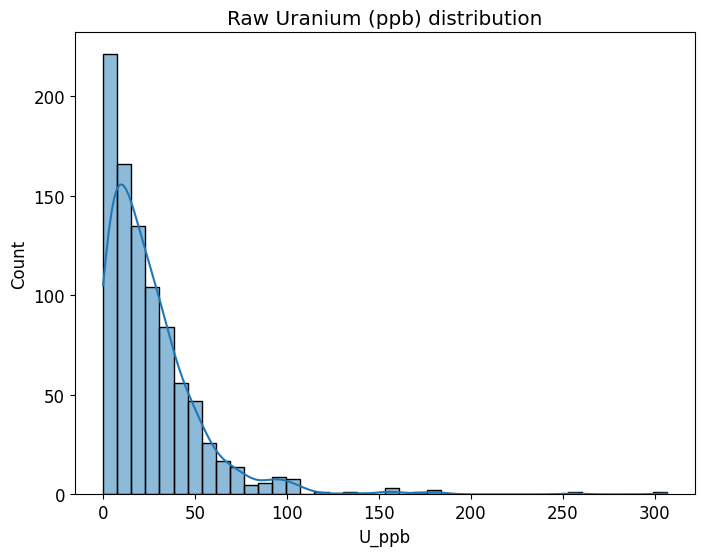

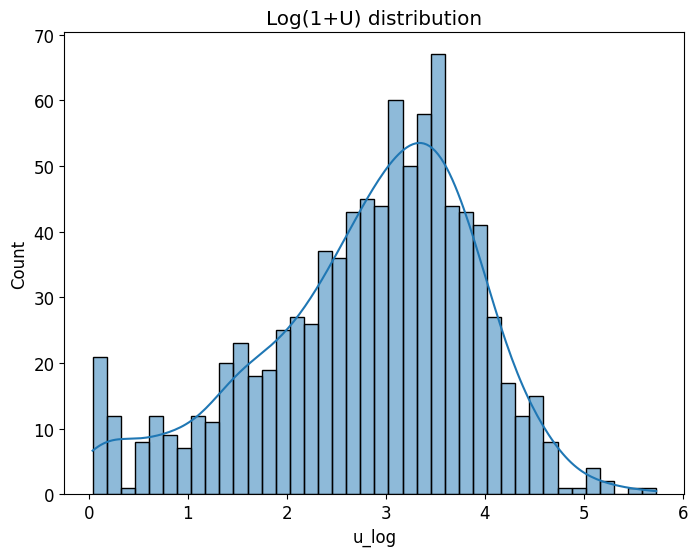

In [5]:
# check skew and apply log-transform if data is strongly skewed
import seaborn as sns
sns.histplot(df2023[u_col], bins=40, kde=True)
plt.title("Raw Uranium (ppb) distribution")
plt.show()

# if strongly right-skewed, use log1p for stability
df2023["u_log"] = np.log1p(df2023[u_col])
sns.histplot(df2023["u_log"], bins=40, kde=True)
plt.title("Log(1+U) distribution")
plt.show()

In [6]:
geometry = [Point(xy) for xy in zip(df2023[lon_col], df2023[lat_col])]
gdf2023  = gpd.GeoDataFrame(df2023, geometry=geometry, crs="EPSG:4326")
gdf2023.head()

,Latitude,Longitude,U_ppb,u_log,geometry
0,31.9070,74.7391,0.57,0.451076,POINT (74.7391 31.907)
1,31.9059,74.8189,3.77,1.562346,POINT (74.8189 31.9059)
2,31.9046,74.8904,3.04,1.396245,POINT (74.8904 31.9046)
3,31.9534,74.8453,1.04,0.712950,POINT (74.8453 31.9534)
4,31.9667,74.9111,0.11,0.104360,POINT (74.9111 31.9667)


In [7]:
# create spatial clusters via KMeans for cross-validation folds
coords = df2023[[lat_col, lon_col]].values
n_splits = 5  # number of folds
kmeans = KMeans(n_clusters=n_splits, random_state=RANDOM_STATE).fit(coords)
df2023["spatial_cluster"] = kmeans.labels_
df2023["spatial_cluster"].value_counts().sort_index()

spatial_cluster
0    299
1      6
2      1
3    320
4    282
Name: count, dtype: int64

In [8]:
# Kernel: constant * Matern + white noise
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-3, 1e3), nu=1.5) \
         + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-6, 1e1))

gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=RANDOM_STATE, n_restarts_optimizer=5)

pipeline = Pipeline([
    ("scaler", StandardScaler()),                 # scale lat/lon
    ("gpr", gpr)
])

In [9]:
# spatial cross-validation using clusters
from sklearn.model_selection import GroupKFold

X = df2023[[lat_col, lon_col]].values
y = df2023["u_log"].values  # using log target
groups = df2023["spatial_cluster"].values

gkf = GroupKFold(n_splits=n_splits)

cv_results = []
fold = 0
preds = np.zeros_like(y)
for train_idx, test_idx in gkf.split(X, y, groups=groups):
    fold += 1
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # store predictions for aggregated metrics
    preds[test_idx] = y_pred

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    cv_results.append({"fold": fold, "rmse": rmse, "mae": mae, "r2": r2})
    print(f"Fold {fold}: RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

pd.DataFrame(cv_results)

Fold 1: RMSE=0.8897, MAE=0.7047, R2=-0.0228
Fold 2: RMSE=1.4110, MAE=1.1088, R2=-0.6696
Fold 3: RMSE=0.9533, MAE=0.7050, R2=-0.0790
Fold 4: RMSE=1.0115, MAE=0.7680, R2=-1.3609
Fold 5: RMSE=1.2240, MAE=1.2240, R2=nan


,fold,rmse,mae,r2
0,1,0.889657,0.704698,-0.022849
1,2,1.411050,1.108838,-0.669568
2,3,0.953315,0.705039,-0.078988
3,4,1.011541,0.767999,-1.360947
4,5,1.224030,1.224030,NaN


In [10]:
# aggregated evaluation on all points (back-transform)
# y and preds are in log-space. Convert back: expm1
y_true_ppb = np.expm1(y)     # ground truth in ppb
y_pred_ppb = np.expm1(preds)

rmse_ppb = np.sqrt(mean_squared_error(y_true_ppb, y_pred_ppb))
mae_ppb = mean_absolute_error(y_true_ppb, y_pred_ppb)
r2_ppb = r2_score(y_true_ppb, y_pred_ppb)

print("Aggregated metrics (ppb):")
print(f"RMSE = {rmse_ppb:.3f} ppb")
print(f"MAE  = {mae_ppb:.3f} ppb")
print(f"R2   = {r2_ppb:.3f}")

Aggregated metrics (ppb):
RMSE = 26.513 ppb
MAE  = 17.377 ppb
R2   = 0.073


In [ ]:
pipeline_final = Pipeline([
    ("scaler", StandardScaler()),
    ("gpr", GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=RANDOM_STATE, n_restarts_optimizer=5))
])

X_all = df2023[[lat_col, lon_col]].values
y_all = df2023["u_log"].values

print("Training final model on all 2023 samples...")
pipeline_final.fit(X_all, y_all)

# save model
joblib.dump(pipeline_final, "../models/gpr_spatial_pipeline_2023.joblib")
print("Saved pipeline to ../models/gpr_spatial_pipeline_2023.joblib")

Training final model on all 2023 samples...
Saved pipeline to ../models/gpr_spatial_pipeline_2023.joblib


: 

In [ ]:
# build a bounding box around your data and predict on a grid
buffer = 0.2  # degrees, adjust smaller for higher precision
minx, miny, maxx, maxy = df2023[lon_col].min() - buffer, df2023[lat_col].min() - buffer, df2023[lon_col].max() + buffer, df2023[lat_col].max() + buffer

# define grid resolution (degrees); smaller -> finer grid, more compute
grid_res = 0.02
xx = np.arange(minx, maxx, grid_res)
yy = np.arange(miny, maxy, grid_res)
gx, gy = np.meshgrid(xx, yy)
grid_points = np.column_stack([gy.ravel(), gx.ravel()])  # note: earlier used [lat, lon] order

# predict log-space then back-transform
log_pred_grid = pipeline_final.predict(grid_points)
pred_grid_ppb = np.expm1(log_pred_grid)

# convert predictions to GeoDataFrame for plotting
grid_df = pd.DataFrame({
    "lat": grid_points[:, 0],
    "lon": grid_points[:, 1],
    "u_ppb": pred_grid_ppb
})
gdf_grid = gpd.GeoDataFrame(grid_df, geometry=gpd.points_from_xy(grid_df.lon, grid_df.lat), crs="EPSG:4326")
gdf_grid.head()

In [ ]:
# scatter map of predicted grid and points
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# plot prediction as scatter (this can be heavy — decimate if necessary)
sc = ax.scatter(gdf_grid.geometry.x, gdf_grid.geometry.y, c=gdf_grid["u_ppb"], cmap="RdYlGn_r", s=10, alpha=0.8)
plt.colorbar(sc, label="Predicted U (ppb)")
# overlay actual sample points
ax.scatter(df2023[lon_col], df2023[lat_col], c="k", s=20, label="samples", edgecolor="white")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
ax.set_title("GPR-predicted Uranium (ppb) - 2023 (grid)")
ax.legend()
plt.show()

In [ ]:
# save grid predictions and sample predictions if needed
gdf_grid[["lat", "lon", "u_ppb"]].to_csv("results/prediction_grid_2023_gpr.csv", index=False)
df2023[["latitude", "longitude", u_col, "u_log"]].to_csv("results/samples_2023.csv", index=False)
print("Saved grid and sample CSVs in results/")